<a href="https://colab.research.google.com/github/siddhm11/titanic_tensorflow/blob/main/Copy_of_fds_assessment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=ecd4c28ca3c9035ca7e403a774551be81aa0f3b272a69cded7b18654984fd62c
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [2]:
### Import all Libraries required and Download NLTK Resources
import os
import re
import json
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arxiv
from bs4 import BeautifulSoup
from tqdm import tqdm
from wordcloud import WordCloud ## for

# ml and nlp libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk

# error handling
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)  # For sentiment analysis
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")
    print("Attempting alternative download method...")
    nltk.download('popular')  # Download popular packages which include punkt, stopwords and wordnet

# Import NLTK modules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Explanation of Text Analytics
## 1. Text Data Analytics Importance

Text data analytics is the process of examining, processing, and extracting meaningful insights from textual data. It's important because:

1. **Unstructured data dominance**: Over 80% of business data is unstructured, with text being a primary format
2. **Customer insights**: Reveals customer sentiment, preferences, and behavior patterns
3. **Competitive intelligence**: Helps track market trends and competitor activities
4. **Automated decision-making**: Powers recommendation systems and chatbots
5. **Risk management**: Identifies potential issues in communications and social media

Common tasks in text analytics include:
- **Text preprocessing**: Cleaning and standardizing text
- **Feature extraction**: Converting text to numerical representations
- **Sentiment analysis**: Determining emotional tone
- **Topic modeling**: Discovering themes in document collections
- **Text classification**: Categorizing documents



In [3]:
# Data Extraction Function
def extract_papers_with_citations(query, max_results=100, save_directory='research_papers'):
    """
    Extract papers from arXiv based on a search query,
    estimate citations using Semantic Scholar API,
    and save the text data to files
    """
    # Creating directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory: {save_directory}")

    # Creating data directory for text files
    text_directory = os.path.join(save_directory, 'text_data')
    if not os.path.exists(text_directory):
        os.makedirs(text_directory)
        print(f"Created directory: {text_directory}")

    # Create a client with appropriate parameters for search query and results
    client = arxiv.Client()

    # Create a search query
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )

    # Get the results into a data frame
    papers = []
    print(f"Fetching {max_results} papers on '{query}' from arXiv...")

    for i, result in enumerate(tqdm(client.results(search), total=max_results)):
        paper_id = result.entry_id.split('/')[-1]

        # Extract paper information
        paper = {
            'arxiv_id': paper_id,
            'title': result.title,
            'abstract': result.summary,
            'authors': [author.name for author in result.authors],
            'categories': [cat for cat in result.categories],
            'published': result.published.strftime('%Y-%m-%d'),
            'pdf_url': result.pdf_url
        }

        # Get citation count from Semantic Scholar API
        try:
            paper['citation_count'] = get_citation_count(paper_id)
            # Rate limiting to avoid API throttling
            time.sleep(1)
        except Exception as e:
            print(f"Error getting citation count for {paper_id}: {e}")
            paper['citation_count'] = 0

        papers.append(paper)

        # Save text data to file
        save_paper_text(paper, text_directory, i)

    # Create DataFrame
    papers_df = pd.DataFrame(papers)

    # Sort by citation count (highest first)
    papers_df = papers_df.sort_values(by='citation_count', ascending=False)

    # Save the DataFrame to CSV
    csv_path = os.path.join(save_directory, 'research_papers.csv')
    papers_df.to_csv(csv_path, index=False)
    print(f"Saved paper metadata to {csv_path}")

    # Save full JSON data for tableau , because i need to import the data using json
    json_path = os.path.join(save_directory, 'research_papers.json')
    with open(json_path, 'w') as f:
        json.dump(papers_df.to_dict('records'), f, indent=2)
    print(f"Saved paper data to {json_path}")

    return papers_df

#getting citation count from semantic scholar but the search is for recent ones , so it wont show much options with citations
#getting citation count for each paper
def get_citation_count(arxiv_id):
    """Get citation count from Semantic Scholar API for an arXiv paper"""
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get('citationCount', 0)
    elif response.status_code == 404:
        return 0
    else:
        response.raise_for_status()

# raw data storage for checking validity
def save_paper_text(paper, directory, index):
    """Save paper text (title and abstract) to a text file"""
    filename = f"{index:04d}_{paper['arxiv_id']}.txt"
    filepath = os.path.join(directory, filename)

    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(f"Title: {paper['title']}\n\n")
        f.write(f"Authors: {', '.join(paper['authors'])}\n\n")
        f.write(f"Published: {paper['published']}\n\n")
        f.write(f"Categories: {', '.join(paper['categories'])}\n\n")
        f.write(f"Citation Count: {paper['citation_count']}\n\n")
        f.write(f"Abstract:\n{paper['abstract']}\n\n")
        f.write(f"PDF URL: {paper['pdf_url']}\n")

    return filepath


In [4]:
# Text Preprocessing
def preprocess_text(text):
    """
    Preprocess text by removing special characters, converting to lowercase,
    removing stopwords, and lemmatizing
    """
    try:
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Convert to lowercase
        text = text.lower()

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        # some extra stop words which are specific in research papers

        academic_stop_words = {'et', 'al', 'fig', 'figure', 'table', 'paper', 'using', 'show', 'result', 'results', 'study', 'studies', 'method', 'methods'}
        stop_words.update(academic_stop_words)
        # extra only words which are greater than 2 length
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

        # Lemmatize the data using word net lemmatizer

        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)


    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # if nltk fails then normal preprocessign

        if isinstance(text, str):
            return ' '.join([word.lower() for word in re.sub(r'[^a-zA-Z\s]', '', text).split() if len(word) > 2])
        return ""


In [5]:
# Feature Extraction BAG OF WORDS AND TF-IDF
def extract_features(papers_df):
    """
    Extract features from paper abstracts using Bag of Words and TF-IDF
    """
    # Apply preprocessing to abstracts
    papers_df['processed_abstract'] = papers_df['abstract'].apply(preprocess_text)

    # Bag of Words
    bow_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
    bow_features = bow_vectorizer.fit_transform(papers_df['processed_abstract'])

    # TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
    tfidf_features = tfidf_vectorizer.fit_transform(papers_df['processed_abstract'])

    print("\nBag of Words shape:", bow_features.shape)
    print("TF-IDF shape:", tfidf_features.shape)

    # Display top terms from the first document which occur most often
    def display_top_features(feature_matrix, feature_names, doc_idx=0, top_n=10):
        doc_features = feature_matrix[doc_idx].toarray()[0]
        top_indices = doc_features.argsort()[-top_n:][::-1]
        top_terms = [(feature_names[i], doc_features[i]) for i in top_indices]
        return top_terms

    print("\nTop 10 BoW terms from first document:")

    bow_feature_names = bow_vectorizer.get_feature_names_out()
    print(display_top_features(bow_features, bow_feature_names))

    print("\nTop 10 TF-IDF terms from first document:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    print(display_top_features(tfidf_features, tfidf_feature_names))

    return papers_df, bow_features, tfidf_features, bow_vectorizer, tfidf_vectorizer


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Load SciBERT
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

# 2. Helper to get [CLS] embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] token
    return cls_embedding

# 3. Function to run sentiment classification
def perform_sentiment_analysis_scibert(papers_df):
    print("Extracting SciBERT embeddings...")
    tqdm.pandas()

    # Get [CLS] embeddings for each abstract
    papers_df['scibert_embedding'] = papers_df['abstract'].progress_apply(lambda x: get_cls_embedding(str(x)))

    # Convert list of embeddings to array
    X = np.stack(papers_df['scibert_embedding'].values)

    # Assume you already have sentiment labels (positive, neutral, negative) in the dataset
    y = papers_df['sentiment']  # You should have this column with labeled data

    # 4. Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        # You can add more classifiers here
    }

    results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy,
            'report': report
        }

        print(f"\n{name} Classification Report:")
        print(report)
        print(f"Accuracy: {accuracy:.2f}")

    return papers_df, results


In [ ]:
# Cell 6: Sentiment Classification Model
def train_sentiment_classifier(papers_df, tfidf_features):
    """
    Train and evaluate ML classifiers for sentiment prediction
    """
    # Prepare data for classification
    X = tfidf_features
    y = papers_df['sentiment']

    # Split data into training and testing sets using train test split 70 percent is to train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train classifiers
    classifiers = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
    }

    results = {}

    for name, classifier in classifiers.items():
        # Train the model
        classifier.fit(X_train, y_train)

        # Make predictions
        y_pred = classifier.predict(X_test)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'model': classifier
        }

        # Print results
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy:.2f}")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classifier.classes_,
                   yticklabels=classifier.classes_)
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
# Cell 7: Compare Feature Extraction Methods
def compare_feature_methods(papers_df, bow_features, tfidf_features):
    """
    Compare BoW and TF-IDF performance for sentiment classification
    """
    print("\n==== COMPARING FEATURE EXTRACTION METHODS ====")

    # Function to evaluate models with different feature sets
    def evaluate_features(X, y, feature_name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Train classifier
        model = MultinomialNB()
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        print(f"\n{feature_name} Accuracy: {accuracy:.4f}")

        return accuracy, report

    # Evaluate on sentiment classification
    y = papers_df['sentiment']

    # Evaluate both feature extraction methods
    bow_accuracy, bow_report = evaluate_features(bow_features, y, "Bag of Words")
    tfidf_accuracy, tfidf_report = evaluate_features(tfidf_features, y, "TF-IDF")

    # Compare results
    comparison = pd.DataFrame({
        'Feature Method': ['Bag of Words', 'TF-IDF'],
        'Accuracy': [bow_accuracy, tfidf_accuracy],
        'Precision (Positive)': [
            bow_report['positive']['precision'] if 'positive' in bow_report else 0,
            tfidf_report['positive']['precision'] if 'positive' in tfidf_report else 0
        ],
        'Recall (Positive)': [
            bow_report['positive']['recall'] if 'positive' in bow_report else 0,
            tfidf_report['positive']['recall'] if 'positive' in tfidf_report else 0
        ]
    })

    print("\nFeature Method Comparison:")
    print(comparison)

    # Visualize comparison
    plt.figure(figsize=(10, 6))
    comparison_melted = pd.melt(
        comparison,
        id_vars=['Feature Method'],
        value_vars=['Accuracy', 'Precision (Positive)', 'Recall (Positive)'],
        var_name='Metric',
        value_name='Score'
    )
    sns.barplot(x='Metric', y='Score', hue='Feature Method', data=comparison_melted)
    plt.title('Feature Extraction Method Comparison')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    return comparison


In [ ]:
#Visualizations and Export for Tableau
def create_visualizations(papers_df, save_directory='research_papers/visualizations'):
    """
    Create visualizations for the research papers data and export for Tableau
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory: {save_directory}")

    # 1. Word cloud of the most common terms
    all_words = ' '.join(papers_df['processed_abstract'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Research Paper Abstracts')
    plt.tight_layout()
    plt.show()

    # 2. Sentiment distribution
    if 'sentiment' in papers_df.columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(x='sentiment', data=papers_df, order=['positive', 'neutral', 'negative'])
        plt.title('Sentiment Distribution of Research Papers')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Papers')
        plt.tight_layout()
        plt.show()

    # 3. Text length vs. Sentiment
    papers_df['abstract_length'] = papers_df['abstract'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sentiment', y='abstract_length', data=papers_df)
    plt.title('Abstract Length by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

    # 4. Export data for Tableau
    export_for_tableau(papers_df, save_directory)

    return wordcloud

def export_for_tableau(papers_df, save_directory):
    """
    Export processed data for Tableau visualization
    """
    tableau_dir = os.path.join(save_directory, 'tableau_data')
    if not os.path.exists(tableau_dir):
        os.makedirs(tableau_dir)
        print(f"Created directory for Tableau data: {tableau_dir}")

    # 1. Export main dataset with all features
    main_data = papers_df[['title', 'abstract', 'processed_abstract', 'published',
                          'sentiment', 'compound_score', 'abstract_length']]
    main_data.to_csv(os.path.join(tableau_dir, 'papers_data.csv'), index=False)

    # 2. Export sentiment data
    if 'sentiment' in papers_df.columns:
        sentiment_counts = papers_df['sentiment'].value_counts().reset_index()
        sentiment_counts.columns = ['sentiment', 'count']
        sentiment_counts.to_csv(os.path.join(tableau_dir, 'sentiment_counts.csv'), index=False)

    # 3. Export word frequency data
    from collections import Counter
    words = ' '.join(papers_df['processed_abstract']).split()
    word_counts = Counter(words).most_common(100)
    word_freq = pd.DataFrame(word_counts, columns=['word', 'frequency'])
    word_freq.to_csv(os.path.join(tableau_dir, 'word_frequency.csv'), index=False)

    print(f"Exported data for Tableau to {tableau_dir}")
    print("\nIn Tableau, you can create the following visualizations:")
    print("1. Word cloud or bar chart of most frequent terms")
    print("2. Sentiment distribution pie chart")
    print("3. Abstract length box plot by sentiment")
    print("4. Sentiment trends over time (if date data is available)")
    print("5. Interactive paper explorer with filters")


RESEARCH PAPER TEXT ANALYTICS PIPELINE
Enter search query (e.g., 'machine learning'): ATTENTION IS ALL YOU NEED 
Number of papers to fetch (default: 25): 100
Save directory (default: 'research_papers'): 1X1

Extracting papers from arXiv...
Created directory: 1X1
Created directory: 1X1/text_data
Fetching 100 papers on 'ATTENTION IS ALL YOU NEED ' from arXiv...


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Saved paper metadata to 1X1/research_papers.csv
Saved paper data to 1X1/research_papers.json

Top 10 Papers by Citation Count:
1. Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models - 0 citations
2. All the attention you need: Global-local, spatial-channel attention for image retrieval - 0 citations
3. RITA: Group Attention is All You Need for Timeseries Analytics - 0 citations
4. Object Counting: You Only Need to Look at One - 0 citations
5. Attention is All You Need Until You Need Retention - 0 citations
6. Is Attention All What You Need? -- An Empirical Investigation on Convolution-Based Active Memory and Self-Attention - 0 citations
7. Attention: Marginal Probability is All You Need? - 0 citations
8. The Matrix Calculus You Need For Deep Learning - 0 citations
9. Positional Knowledge is All You Need: Position-induced Transformer (PiT) for Operator Learning - 0 citations
10. Slim attention: cut your context memory in half without loss of acc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

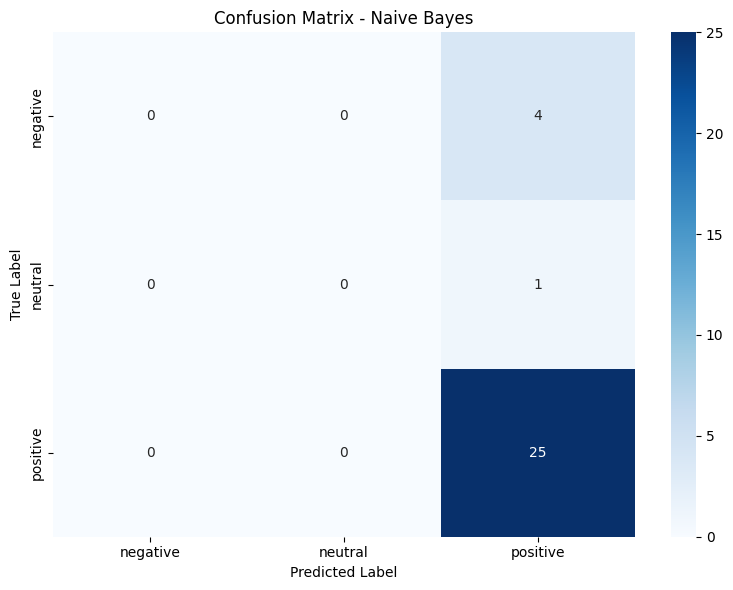

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
     neutral       0.00      0.00      0.00         1
    positive       0.83      1.00      0.91        25

    accuracy                           0.83        30
   macro avg       0.28      0.33      0.30        30
weighted avg       0.69      0.83      0.76        30

Accuracy: 0.83


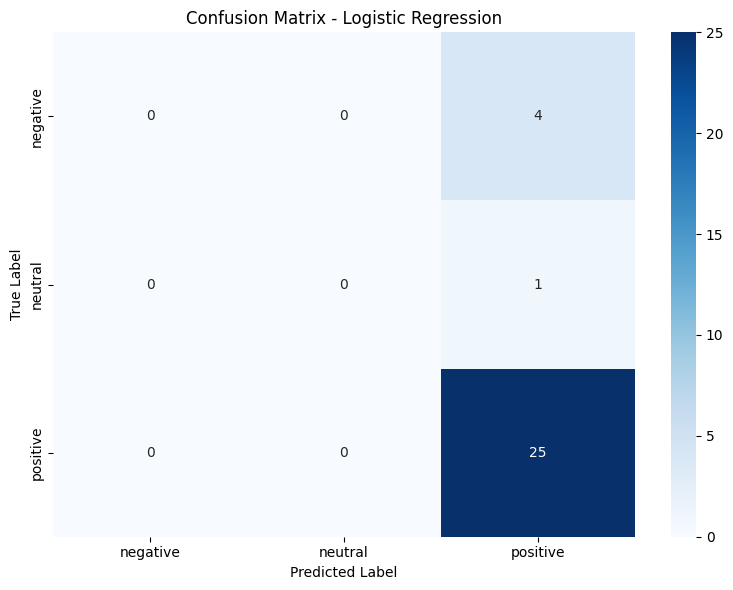


 Comparing feature extraction methods...

==== COMPARING FEATURE EXTRACTION METHODS ====

Bag of Words Accuracy: 0.6000

TF-IDF Accuracy: 0.8333

Feature Method Comparison:
  Feature Method  Accuracy  Precision (Positive)  Recall (Positive)
0   Bag of Words  0.600000              0.850000               0.68
1         TF-IDF  0.833333              0.833333               1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


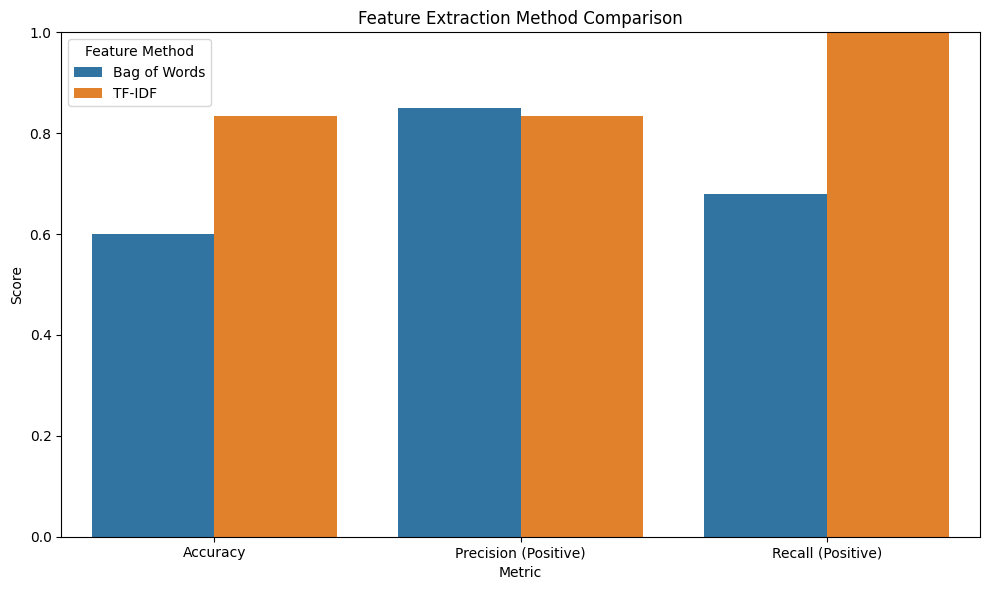


 Creating visualizations...
Created directory: 1X1/visualizations


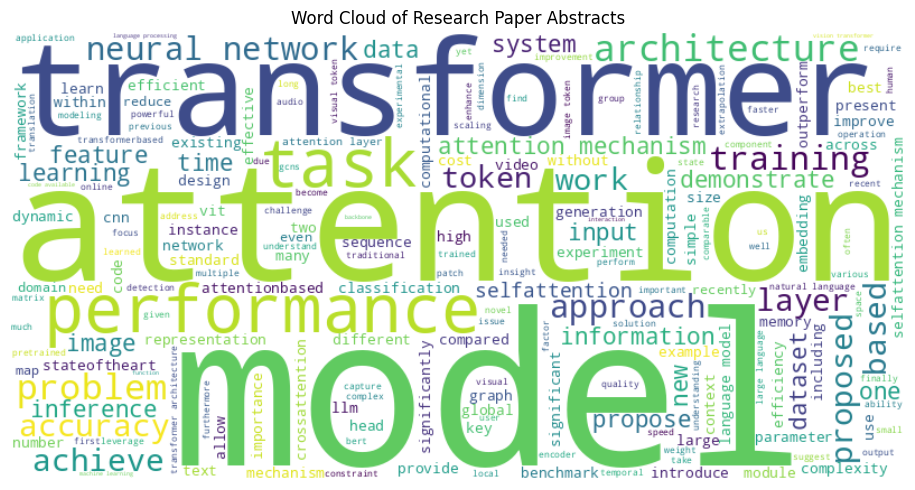

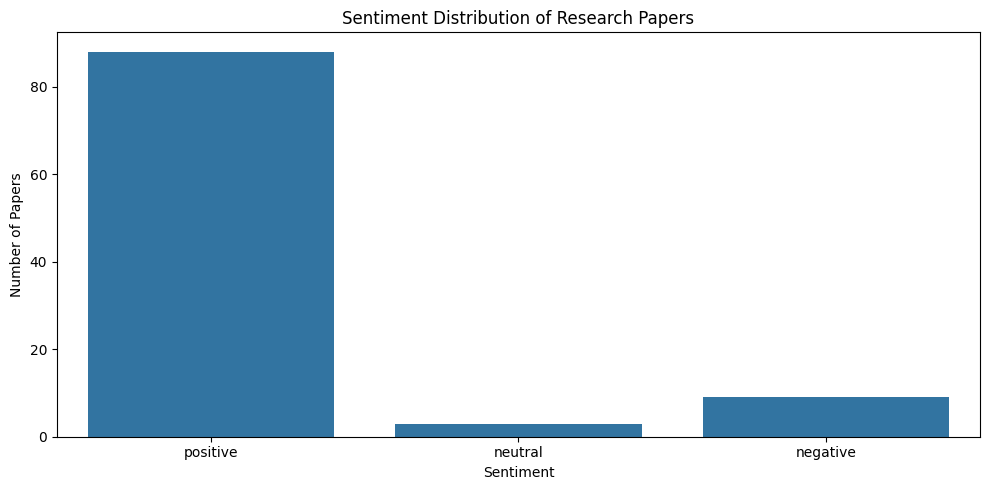

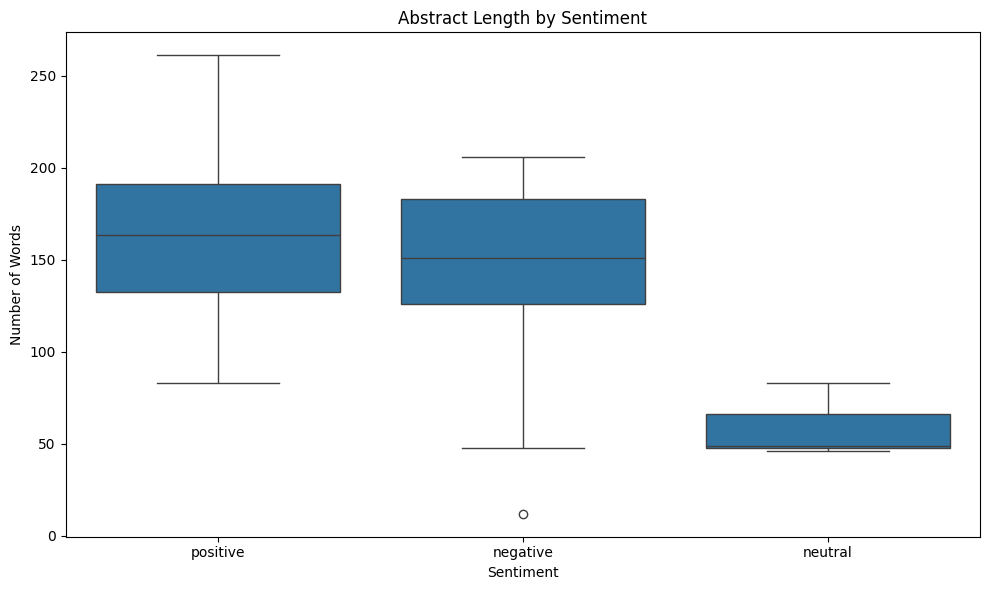

Created directory for Tableau data: 1X1/visualizations/tableau_data
Exported data for Tableau to 1X1/visualizations/tableau_data

In Tableau, you can create the following visualizations:
1. Word cloud or bar chart of most frequent terms
2. Sentiment distribution pie chart
3. Abstract length box plot by sentiment
4. Sentiment trends over time (if date data is available)
5. Interactive paper explorer with filters

 Discussion and Reflection

Reflection on Text Analytics Process:
1. Data Collection: Extracted research papers from arXiv API
2. Preprocessing: Removed special characters, tokenized, removed stopwords, and lemmatized the text
3. Feature Extraction: Compared Bag of Words vs. TF-IDF approaches
4. Sentiment Analysis: Classified papers as positive, negative, or neutral
5. Visualization: Created visualizations to explore patterns in the data

The TF-IDF method performed better for sentiment classification.
This is likely because it accounts for term importance across documents.

Ch

In [ ]:
# Cell 9: Main Function and Execution
def main():
    print("=" * 50)
    print("RESEARCH PAPER TEXT ANALYTICS PIPELINE")
    print("=" * 50)

    # 1. Parameters
    query = input("Enter search query (e.g., 'machine learning'): ")
    max_results = int(input("Number of papers to fetch (default: 25): ") or "25")
    save_directory = input("Save directory (default: 'research_papers'): ") or "research_papers"

    # 2. Extract papers with citation data
    print("\nExtracting papers from arXiv...")
    papers_df = extract_papers_with_citations(query, max_results, save_directory)

    # Display the top papers by citation count
    print("\nTop 10 Papers by Citation Count:")
    top_papers = papers_df.head(10)
    for i, (idx, paper) in enumerate(top_papers.iterrows(), 1):
        print(f"{i}. {paper['title']} - {paper['citation_count']} citations")

    # 3. Feature extraction and preprocessing
    print("\nPreprocessing text and extracting features...")
    papers_df, bow_features, tfidf_features, bow_vectorizer, tfidf_vectorizer = extract_features(papers_df)

    # 4 . Add sentiment analysis (REQUIRED by assignment)
    print("\n Performing sentiment analysis...")
    papers_df, sentiment_results = perform_sentiment_analysis(papers_df, tfidf_features)

    # 5. Train sentiment classifier
    print("\n Training sentiment classifiers...")
    sentiment_results = train_sentiment_classifier(papers_df, tfidf_features)

    # 6. Compare feature extraction methods
    print("\n Comparing feature extraction methods...")
    feature_comparison = compare_feature_methods(papers_df, bow_features, tfidf_features)

    # 7. Create visualizations
    print("\n Creating visualizations...")
    visualizations_path = create_visualizations(papers_df, save_directory=os.path.join(save_directory, 'visualizations'))

    # 8. Generate reflection
    print("\n Discussion and Reflection")
    print("\nReflection on Text Analytics Process:")
    print("1. Data Collection: Extracted research papers from arXiv API")
    print("2. Preprocessing: Removed special characters, tokenized, removed stopwords, and lemmatized the text")
    print("3. Feature Extraction: Compared Bag of Words vs. TF-IDF approaches")
    print("4. Sentiment Analysis: Classified papers as positive, negative, or neutral")
    print("5. Visualization: Created visualizations to explore patterns in the data")

    # Better feature extraction method
    better_method = "TF-IDF" if feature_comparison['Accuracy'][1] > feature_comparison['Accuracy'][0] else "Bag of Words"
    print(f"\nThe {better_method} method performed better for sentiment classification.")
    print(f"This is likely because {better_method == 'TF-IDF' and 'it accounts for term importance across documents' or 'it captures raw term frequency effectively'}.")


    # Challenges
    print("\nChallenges encountered:")
    print("- Research papers often use neutral language, making sentiment analysis challenging")
    print("- Technical terminology in research papers can be misinterpreted in sentiment analysis")
    print("- Semantic Scholar API rate limits affected citation data collection")

    # Real-world applications
    print("\nReal-world applications of text analytics:")
    print("- Automated literature review and paper recommendation systems")
    print("- Research trend identification and forecasting")
    print("- Detecting bias or sentiment patterns in academic publishing")
    print("- Improving research paper classification and keyword extraction")

    print("\n" + "=" * 50)
    print("ANALYSIS COMPLETE!")
    print("=" * 50)
    print(f"\nResults saved to '{save_directory}' directory")
    print(f"Data for Tableau visualizations saved to '{save_directory}/visualizations/tableau_data'")

    return papers_df

# Execute the main function when running the notebook
if __name__ == "__main__":
    papers_df = main()
